In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1. Read in the Data 

Using pd.read_csv, I read in the data. By opening the file, at a cursory glance you can see the seperator is a tab. The names are given by the assignment. 

In [2]:
gold = pd.read_csv("gold.txt", sep = "\t", names = ["url", "category"]) 
labels = pd.read_csv("labels.txt", sep = "\t", names = ["turk", "url", "category"]) 


### 2. Split into Two DataFrames

I created a mask that is true when a label url is in gold. I also made a mask that is the opposite of that. Applying these to the labels set splits it into two data frames. 

In [3]:
mask1 = labels["url"].isin(gold["url"])
mask2 = ~mask1 
labels_on_gold = labels[mask1] 
labels_unknown = labels[mask2] 
labels_on_gold[0:10]


,turk,url,category
245,A1253FXHCZ9CWM,http://0800-horoscope.com,G
246,A153PKAL7OAY36,http://0800-horoscope.com,G
247,A1FV9SAPL5C6KY,http://0800-horoscope.com,G
248,A1JTOT0DWM6QGL,http://0800-horoscope.com,G
249,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G
250,A21US576U8SCO4,http://0800-horoscope.com,G
251,A22C0PJUBFJTI0,http://0800-horoscope.com,G
252,A270HOAHEVIFW0,http://0800-horoscope.com,G
253,A2EG8FHODTEV63,http://0800-horoscope.com,R
254,A2LM400F4F0V0M,http://0800-horoscope.com,G


### 3. Compute accuracies of Turks

I instatiated a dataframe containing the number of ratings done by each turk on the gold set. Then I dropped category which was unneeded. Then I sorted it which I probably didn't need to do. Then I changed the name of that column. Then I merged the labels_on_gold with gold to get two columns of the true and user categories. Then when they matched I made a column that had 1 or 0 (if they didn't). Then I added those up. Then I merged that onto my rater_goodness and did the math for the last column before cleaning it up. 

In [4]:
rater_goodness = labels_on_gold.groupby("turk").count() 
rater_goodness = rater_goodness.drop("category", 1) 
rater_goodness = rater_goodness.sort_values("url", ascending = False)
rater_goodness["Number of Ratings"] = rater_goodness["url"]
rater_goodness = rater_goodness.drop("url", 1) 
merged = labels_on_gold.merge(gold, on = "url")
merged["c"] = np.where(merged["category_x"]==merged["category_y"], 1, 0)

temp = merged.groupby("turk")[["c"]].agg(sum) 
temp = temp.reset_index() 
rater_goodness = rater_goodness.reset_index()
rater_goodness = temp.merge(rater_goodness, on = "turk").sort_values("Number of Ratings", ascending = False)
rater_goodness["Average Correctness"] = rater_goodness["c"]/rater_goodness["Number of Ratings"] 
rater_goodness = rater_goodness.drop("c",1) 
rater_goodness[1:10]


,turk,Number of Ratings,Average Correctness
8,A153PKAL7OAY36,148,0.722973
81,A2BTR0GQ5B5JI6,126,0.523810
256,ATVALOQVDCMZW,103,0.854369
266,AZSDW7JJL5VA7,100,0.680000
164,A3GE97GX3OXJTW,85,0.658824
172,A3JMQDTEKRE5X6,80,0.675000
97,A2JP3HEL3J25AJ,80,0.687500
175,A3MA9V9UPGCOK7,71,0.774648
245,APYV9Y0DFZFVP,71,0.746479


### 4. Odds Ratios

I did the math according to the odds formula. 

In [5]:
rater_goodness["odds"] = rater_goodness["Average Correctness"]/(1.001-rater_goodness["Average Correctness"]) 
rater_goodness1 = rater_goodness
rater_goodness = rater_goodness.set_index("turk")
rater_goodness[0:10]

,Number of Ratings,Average Correctness,odds
turk,,,
A31OCN4MNHUQ6W,184,0.777174,3.472222
A153PKAL7OAY36,148,0.722973,2.600369
A2BTR0GQ5B5JI6,126,0.523810,1.097695
ATVALOQVDCMZW,103,0.854369,5.826657
AZSDW7JJL5VA7,100,0.680000,2.118380
A3GE97GX3OXJTW,85,0.658824,1.925391
A3JMQDTEKRE5X6,80,0.675000,2.070552
A2JP3HEL3J25AJ,80,0.687500,2.192982
A3MA9V9UPGCOK7,71,0.774648,3.422313


### 5. Most Accurate Turks

I filtered out the ones who had less than 20 ratings and sorted them by their correctness

In [6]:
accuracy = rater_goodness1.groupby("turk").filter(lambda x: x["Number of Ratings"]>=20) 
topTen = accuracy.sort_values("Average Correctness", ascending = False)[0:10] 
topTen

,turk,Number of Ratings,Average Correctness,odds
122,A2U0R4X38GUKZE,20,0.950000,18.627451
61,A22C0PJUBFJTI0,36,0.916667,10.869565
65,A23YQUBXZPKILZ,24,0.875000,6.944444
256,ATVALOQVDCMZW,103,0.854369,5.826657
26,A1HIXWH4OXT8S4,40,0.825000,4.687500
133,A3220HG1O83HQ4,22,0.818182,4.475385
57,A20PWAB7G3HDHU,20,0.800000,3.980100
136,A32W20KGQXS0LL,25,0.800000,3.980100
227,AJSJVK40F5HM6,28,0.785714,3.649635
132,A31OCN4MNHUQ6W,184,0.777174,3.472222


### 6. Ratings Counts vs Accuracy

It does not appear that people who do a lot of ratings are more correct than people who don't. The only high ratings appear when the number of ratings is low. However, the more ratings someone does, it seems they're less likely to get most of them wrong. 

C:\Users\vince\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


R squared: 0.00205139994014


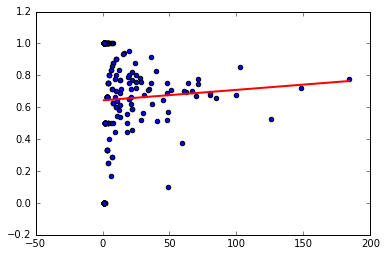

In [7]:
result = pd.ols(x= rater_goodness1["Number of Ratings"], y = rater_goodness1["Average Correctness"]) 
y_expected = result.beta['intercept'] + rater_goodness1['Number of Ratings'] * result.beta['x']
scatter(rater_goodness1["Number of Ratings"], rater_goodness1["Average Correctness"])
plot(rater_goodness1['Number of Ratings'], y_expected, linewidth=2, color='red') 
print "R squared: " + str(result.r2)

### 7. Overall Predicted Odds

I sorted by turk to get the individuals then filtered so it only kept things where Number of Ratings was greater than the 75th percentile. Then I applied a mask based on this filter on labels_unknown. Then I merged them on turk to get odds and category in the same dataframe. Then I made a pivot table indexed by url, based on category with values of multiplied odds.  

In [8]:
worthyTurk = rater_goodness1.groupby("turk").filter(lambda x: x["Number of Ratings"] >= rater_goodness1["Number of Ratings"].quantile(.75))
labels_unknown75 = labels_unknown[labels_unknown["turk"].isin(worthyTurk["turk"])]

merged = pd.merge(worthyTurk, labels_unknown75, on = "turk")

pt = pd.pivot_table(merged, index= "url", columns = "category", values= "odds", fill_value = 0, aggfunc = np.prod)
pt[0:7]

category,G,P,R,X
url,,,,
http://0-101.net,2.155963,0.000000,0.0,0.0
http://000.cc,1.460583,0.000000,0.0,0.0
http://0000.jp,14.488244,0.000000,0.0,0.0
http://000relationships.com,9.914590,1.851852,0.0,0.0
http://000vitamins.com,3.784982,0.000000,0.0,0.0
http://000webhost.com,11.159502,0.000000,0.0,0.0
http://003my.com,4.912040,0.000000,0.0,0.0


### 8. Predicted Categories

Most methods seem to work on columns so I transposed the pivot table (which is itself a dataframe) and used max and idxmax to get the values I want.  

In [9]:
result_75 = pd.DataFrame()
result_75["Top Category"] = pt.T.idxmax()
result_75["Top Odds"] = pt.T.max()
result_75[0:10]

,Top Category,Top Odds
url,,
http://0-101.net,G,2.155963
http://000.cc,G,1.460583
http://0000.jp,G,14.488244
http://000relationships.com,G,9.914590
http://000vitamins.com,G,3.784982
http://000webhost.com,G,11.159502
http://003my.com,G,4.912040
http://007absolutehardcore.com/early_cumshots/index.html,X,293.252871
http://007swz.cn,G,1.393883


### 9. Predicted Categories using more Turks

The a lot of errors appear to be people mislabeling X things as G or G as X. Probably people who think this is hilarious. They are not as funny as they think. It also appears the 75th percentile rates tend to think many more things are just rated G while the 25th percentile raters split them into more groups. 

In [11]:
worthyTurk2 = rater_goodness1.groupby("turk").filter(lambda x: x["Number of Ratings"] >= rater_goodness1["Number of Ratings"].quantile(.25))
labels_unknown752 = labels_unknown[labels_unknown["turk"].isin(worthyTurk2["turk"])]

merged2 = pd.merge(worthyTurk2, labels_unknown752, on = "turk")

pt2 = pd.pivot_table(merged2, index= "url", columns = "category", values= "odds", fill_value = 0, aggfunc = np.prod) 

result_25 = pd.DataFrame()
result_25["Top Category25"] = pt2.T.idxmax()
result_25["Top Odds25"] = pt2.T.max()

pd.crosstab(result_25["Top Category25"],result_75["Top Category"])

Top Category,G,P,R,X
Top Category25,,,,
G,7911,229,22,70
P,836,263,36,12
R,285,65,120,35
X,237,25,35,429
